In [37]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate, StratifiedKFold

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (10, 6)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

# confusion_matrixの結果からF値を計算する関数
def calculate_f1_from_confusion_matrix(cm):
    """
    confusion_matrixの結果からF1スコアを計算
    
    Args:
        cm: confusion_matrixの結果（2x2配列）
            [[TN, FP],
             [FN, TP]]
    
    Returns:
        float: F1スコア
    """
    # 2値分類の場合
    if cm.shape == (2, 2):
        TN, FP = cm[0, 0], cm[0, 1]
        FN, TP = cm[1, 0], cm[1, 1]
        
        # Precision = TP / (TP + FP)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall = TP / (TP + FN)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return f1, precision, recall
    else:
        raise ValueError("2値分類用の関数です。多クラス分類の場合は別の関数を使用してください。")

In [39]:
# データ収集関数（既存の分析から再利用）
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_logistic(logs_root='Logs'):
    """
    ロジスティック回帰用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無、タイムアウトの有無などを記録
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            
            if not os.path.exists(detected_bugs_path):
                continue
            
            # detected_bugs.csvとexe_time.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                
                # 各行をペアで処理
                for bug_row in bug_reader:
                    
                    # 実行結果を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    
                    if bug_row == ['timeout']:
                        bug_detected = 0
                    elif bug_row == ['null']:
                        bug_detected = 0
                    else:
                        bug_detected = 1

                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected,  # バグ発見の有無（二値）
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    return df

# データ収集
df = collect_data_for_logistic(logs_root="../Logs/")


データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000
mean     500.000000    225.000000     50.000000      1.150000      0.576204
std      408.267192    234.016532     40.010185      0.572303      0.494182
min        0.000000      1.000000      1.000000      1.000000      0.000000
25%        0.000000     50.000000      1.000000      1.000000      0.000000
50%      500.000000    149.500000     50.000000      1.000000      1.000000
75%     1000.000000    300.000000     99.000000      1.000000      1.000000
max     1000.000000    700.000000     99.000000      4.000000      1.000000

バグ発見の有無の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64


# タスク0: バグ発見の有無（二値分類）


## モデルの構築・F値計算

In [40]:
# sklearnを使用したロジスティック回帰（予測精度の評価のため）
# 説明変数と目的変数の準備
X = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df['bug_detected']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")
print(f"\n訓練データの目的変数分布:")
print(y_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y_test.value_counts())

# 標準化（オプション：必要に応じて）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RFの学習
rf_model0_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    min_samples_leaf=0.05,
    n_jobs=-1
)
rf_model0_cv.fit(X_train_scaled, y_train)

# 予測
y_pred = rf_model0_cv.predict(X_test_scaled)
y_pred_proba = rf_model0_cv.predict_proba(X_test_scaled)[:, 1]


訓練データ数: 8640
テストデータ数: 2160

訓練データの目的変数分布:
bug_detected
1    4978
0    3662
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected
1    1245
0     915
Name: count, dtype: int64


In [41]:
# モデルの評価

# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)


print(f"\n【今回のモデル】")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# 混同行列
cm = confusion_matrix(y_test, y_pred)
print("\n【混同行列】")
print(cm)

# ベースラインモデルの予測を作成
y_pred_always_bug = np.ones(len(y_test))

# ベースラインモデルの評価
baseline_accuracy = accuracy_score(y_test, y_pred_always_bug)
baseline_precision = precision_score(y_test, y_pred_always_bug, zero_division=0)
baseline_recall = recall_score(y_test, y_pred_always_bug, zero_division=0)
baseline_f1 = f1_score(y_test, y_pred_always_bug, zero_division=0)

print(f"\n【ベースラインモデル】")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")

# 混同行列
cm = confusion_matrix(y_test, y_pred_always_bug)
print("\n【混同行列】")
print(cm)


【今回のモデル】
Accuracy:  0.8375
Precision: 0.8807
Recall:    0.8305
F1-Score:  0.8549

【混同行列】
[[ 775  140]
 [ 211 1034]]

【ベースラインモデル】
Accuracy:  0.5764
Precision: 0.5764
Recall:    1.0000
F1-Score:  0.7313

【混同行列】
[[   0  915]
 [   0 1245]]


## 十分割交差検証

In [42]:
# 交差検証やっていく
# 10分割交差検証の設定（層化サンプリング）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.pipeline import Pipeline
# 標準化を含むPipelineを作成（交差検証で各foldで標準化を適用）
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, min_samples_leaf=0.05, n_jobs=-1))
])

# 評価指標を定義
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(
    pipeline, X, y, 
    cv=cv, 
    scoring=scoring,
    return_train_score=False,
    return_estimator=False
)

In [43]:
# 結果の出力
# 10分割交差検証を実行
print("="*70)
print("【バグ発見の有無】sklearnのLogisticRegressionによる10分割交差検証")
print("="*70)

# 全体の統計を計算
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision'].mean()
std_precision = cv_results['test_precision'].std()
mean_recall = cv_results['test_recall'].mean()
std_recall = cv_results['test_recall'].std()
mean_f1 = cv_results['test_f1'].mean()
std_f1 = cv_results['test_f1'].std()

print("\n【全体の統計（10分割交差検証）】")
print("-"*70)
print(f"Accuracy (正解率):")
print(f"  平均: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"  範囲: [{cv_results['test_accuracy'].min():.4f}, {cv_results['test_accuracy'].max():.4f}]")

print(f"\nPrecision (適合率):")
print(f"  平均: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"  範囲: [{cv_results['test_precision'].min():.4f}, {cv_results['test_precision'].max():.4f}]")

print(f"\nRecall (再現率):")
print(f"  平均: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"  範囲: [{cv_results['test_recall'].min():.4f}, {cv_results['test_recall'].max():.4f}]")

print(f"\nF1 Score (F値):")
print(f"  平均: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  範囲: [{cv_results['test_f1'].min():.4f}, {cv_results['test_f1'].max():.4f}]")

# 各フォールドの詳細結果
n_folds = len(cv_results['test_accuracy'])
print("\n【各フォールドの詳細結果】")
print("-"*70)
print(f"{'Fold':<6} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-"*70)
for i in range(n_folds):
    print(f"{i+1:<6} {cv_results['test_accuracy'][i]:<12.4f} {cv_results['test_precision'][i]:<12.4f} {cv_results['test_recall'][i]:<12.4f} {cv_results['test_f1'][i]:<12.4f}")

【バグ発見の有無】sklearnのLogisticRegressionによる10分割交差検証

【全体の統計（10分割交差検証）】
----------------------------------------------------------------------
Accuracy (正解率):
  平均: 0.8451 ± 0.0162
  範囲: [0.8167, 0.8787]

Precision (適合率):
  平均: 0.8793 ± 0.0158
  範囲: [0.8430, 0.9085]

Recall (再現率):
  平均: 0.8477 ± 0.0160
  範囲: [0.8266, 0.8778]

F1 Score (F値):
  平均: 0.8631 ± 0.0142
  範囲: [0.8403, 0.8929]

【各フォールドの詳細結果】
----------------------------------------------------------------------
Fold   Accuracy     Precision    Recall       F1 Score    
----------------------------------------------------------------------
1      0.8315       0.8744       0.8266       0.8498      
2      0.8417       0.8767       0.8443       0.8602      
3      0.8352       0.8778       0.8299       0.8531      
4      0.8787       0.9085       0.8778       0.8929      
5      0.8556       0.8820       0.8650       0.8734      
6      0.8602       0.8932       0.8601       0.8763      
7      0.8167       0.8430       0.8376       0.

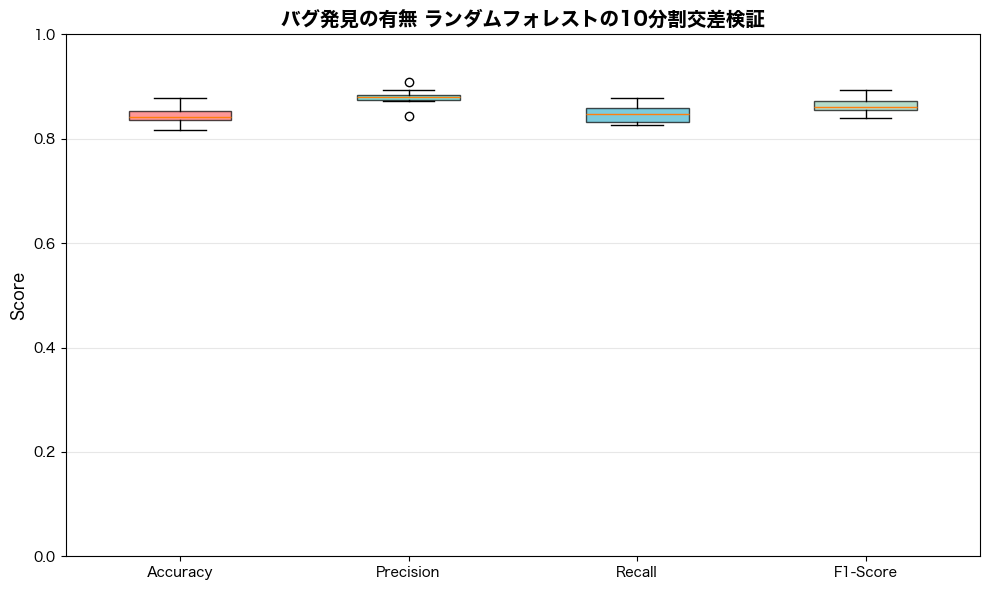

In [44]:
# 交差検証の結果をグラフで表示
# 評価指標のリスト
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# 各評価指標のスコアを取得
test_scores = {
    'accuracy': cv_results['test_accuracy'],
    'precision': cv_results['test_precision'],
    'recall': cv_results['test_recall'],
    'f1': cv_results['test_f1']
}

# 可視化: 箱ひげ図
_, ax = plt.subplots(figsize=(10, 6))

# テストスコアの箱ひげ図
test_data = [test_scores[m] for m in metrics]
bp = ax.boxplot(test_data, tick_labels=metric_labels, patch_artist=True)
# 箱の色を設定
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_title('バグ発見の有無 ランダムフォレストの10分割交差検証', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()